In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing necessary libararies
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import itertools
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [3]:
#reading csv file
corpus=pd.read_csv("/content/drive/MyDrive/DSF trials/preprocessed_annotated_data.csv") 

In [4]:
corpus.head()

,clean_plot_summary,multi_label_genre
0,old old boar manor calls animals farm compares...,"['action', 'cookery', 'war']"
1,teenager living leads gang nightly orgies rand...,"['fiction', 'literature', 'thriller']"
2,text plague divided five town thousands initia...,"['fiction', 'literature', 'utopian']"
3,novel posits space around milky way divided co...,"['fiction', 'literature', 'utopian']"
4,book tells story paul german soldier school ge...,"['fiction', 'literature', 'nonfiction']"


Tuning the output for calling multilabel classification

In [5]:
import ast
corpus['multi_label_genre']=corpus['multi_label_genre'].apply(lambda x: ast.literal_eval(x))

In [6]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

# clean dataset
def clean_dataset(text):
    text = text.lower()
    text = re.sub(r'#','', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    text = re.sub(r'([^\w\d ]+)([\w\d]+)', '\1 \2',text)
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

#remove stop word i.e. the most frequently appeared words 
myOwnStopList=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']


In [7]:
corpus['clean_plot_summary']=corpus['clean_plot_summary'].apply(lambda x: remove_contractions(str(x)))

corpus['clean_plot_summary'] =corpus['clean_plot_summary'].apply(lambda x: clean_dataset(x))
corpus['clean_plot_summary'] = corpus['clean_plot_summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))

Splitting embedding across multiple columns, so that every dimension of embedding acts as a feature

### Multilabel classification output transformation

Calling in Multilabelbinarizer

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()

# transform target variable
y = multilabel_binarizer.fit_transform(corpus['multi_label_genre'])

In [9]:
print(y.shape)

(13132, 30)


Since embeddings here are fetched from a pretrained model, before train test split only we can fetch them


In [10]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')


     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 3.1 MB 29.8 MB/s 
     |████████████████████████████████| 3.3 MB 43.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.1 MB/s 
     |████████████████████████████████| 61 kB 522 kB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 895 kB 51.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=a86308ed26ebcd68ee7de28cf18b6807ec2a0b7de7975b9eb4e6218f620af633
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
corpus['passage_embedding']=corpus['clean_plot_summary'].apply(lambda x: model.encode(x))

In [ ]:
corpus.head()

,clean_plot_summary,multi_label_genre,passage_embedding
0,old old boar manor calls animals farm compares...,"[action, cookery, war]","[-0.00936466, -0.046432283, 0.04785304, -0.004..."
1,teenager living leads gang nightly orgies rand...,"[fiction, literature, thriller]","[-0.025159629, -0.042870175, -0.008320468, 0.0..."
2,text plague divided five town thousands initia...,"[fiction, literature, utopian]","[0.0450471, -0.024600938, 0.011781344, -0.0245..."
3,novel posits space around milky way divided co...,"[fiction, literature, utopian]","[-0.092494026, -0.055143498, -0.03134751, 0.03..."
4,book tells story paul german soldier school ge...,"[fiction, literature, nonfiction]","[-0.05076918, 0.01998265, -0.003516058, 0.0133..."


In [ ]:
column_list_embedding=["embedding"+str(i) for i in range(384)]


corpus[column_list_embedding]=pd.DataFrame(corpus.passage_embedding.values.tolist(),index= corpus.index)

In [ ]:
x=corpus[column_list_embedding]

In [ ]:
print(x.shape)

(13132, 384)


### Train Test split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(10505, 384)
(10505, 30)
(2627, 384)
(2627, 30)


Binary Relevance 

In [ ]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)
from sklearn.ensemble import RandomForestClassifier
model_rf_br=RandomForestClassifier() #binary relevance model
model_rf_cc=RandomForestClassifier() #classifier chain model



In [ ]:
predictions = pd.DataFrame()

In [ ]:
from tqdm import tqdm
import pickle
filepath="/content/drive/MyDrive/DSF trials/binary_relevance_models/"

In [ ]:
for i in tqdm(range(y.shape[1])):
    ytrain_i = ytrain[:,i]
    label="genre"+str(i)
    # train the model using xtrain & this particular genre(y[:,i])
    model_rf_br.fit(xtrain, ytrain_i)
    # compute the training accuracy
    ypred_i = model_rf_br.predict(xtest)
    
    # compute the predicted probabilities for xtest
    test_y_prob = model_rf_br.predict_proba(xtest)[:,0]
    predictions[label] = 1.0-test_y_prob
    filename=filepath+label+".sav"
    pickle.dump(model_rf_br, open(filename, 'wb'))

100%|██████████| 30/30 [14:22<00:00, 28.76s/it]


Classifier Chains

In [25]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
predictions2 = pd.DataFrame()
filepath="/content/drive/MyDrive/DSF trials/classifier_chain_models/"

In [ ]:
for i in tqdm(range(y.shape[1])):
    #print('\n Processing predictions for genre'+str(i))
    ytrain_i = ytrain[:,i]
    label="genre"+str(i)
    # train the model using xtrain & this particular genre(y[:,i])
    model_rf_cc.fit(xtrain, ytrain_i)
    # compute the training accuracy
    y_pred_train_i=model_rf_cc.predict(xtrain)
    ypred_i = model_rf_cc.predict(xtest)
    
    # compute the predicted probabilities for xtest
    test_y_prob = model_rf_cc.predict_proba(xtest)[:,0]
    predictions2[label] = 1.0-test_y_prob
    filename=filepath+label+".sav"
    pickle.dump(model_rf_cc, open(filename, 'wb'))
    add_feature(xtrain,y_pred_train_i)
    add_feature(xtest,ypred_i)
    

100%|██████████| 30/30 [14:39<00:00, 29.31s/it]


Merging results of Binary Relevance and Classifier Chaining

In [ ]:
final_y_test_pred=predictions+predictions2

In [ ]:
res=final_y_test_pred.to_numpy()
res1=final_y_test_pred.to_numpy()

### Converting logits into binary probabilities

In [ ]:
for i in range(res.shape[0]):
  for j in range(res.shape[1]):
    if res[i][j]>0.5:
      res[i][j]=1
    else:
      res[i][j]=0

### Inference

In [ ]:
for i in range(0,50):
  print("\n Test Data point: {} ".format(i))
  print("\n Actual genres: ",multilabel_binarizer.inverse_transform(ytest)[i])
  print("\n Predicted genres: ",multilabel_binarizer.inverse_transform(res)[i])


### Evaluation metrics

In [ ]:
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

def Precision(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_true[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
      return temp/ y_true.shape[0]

def Recall(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_pred[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
      return temp/ y_true.shape[0]

def F1Measure(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
    return temp/ y_true.shape[0]
    
    print(F1Measure(y_true, y_pred))
    
def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])



In [ ]:
print("\n Accuracy: ",Accuracy(ytest,res1))
print("\n Precision: ",Precision(ytest,res1))
print("\n Recall: ",Recall(ytest,res1))
print("\n F1 Measure: ",F1Measure(ytest,res1))
print("\n Hamming Loss: : ",Hamming_Loss(ytest,res1))


 Accuracy:  0.47033749040791545

 Precision:  0.6620987184367502

 Recall:  0.5671547301828996

 F1 Measure:  0.5978104224583164

 Hamming Loss: :  0.08790762593579494


##Inference

In [11]:
test_data=pd.read_csv("/content/drive/MyDrive/DSF trials/01_cleaned_test_dataset.csv")

In [12]:
test_data.head()

,Unnamed: 0,cleaned_text
0,0,sherlock holmes always seldom heard eyes eclip...
1,1,three precisely baker holmes landlady informed...
2,2,slept baker street engaged upon toast king boh...
3,3,great solitary made pride keep suffice may say...
4,4,returned den cook stood well care somewhat neg...


In [13]:
#we will first clean the text
test_data['cleaned_text']=test_data['cleaned_text'].apply(lambda x: remove_contractions(str(x)))

test_data['cleaned_text']=test_data['cleaned_text'].apply(lambda x: clean_dataset(x))
test_data['cleaned_text'] = test_data['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))


In [14]:
#fetch the embeddings
test_data['embedding']=test_data['cleaned_text'].apply(lambda x: model.encode(x))

In [15]:
#split embedding across different columns as induvidual features
column_list_embedding=["embedding"+str(i) for i in range(384)]


test_data[column_list_embedding]=pd.DataFrame(test_data.embedding.values.tolist(),index=test_data.index)

In [16]:
test_x=test_data[column_list_embedding]

In [17]:
test_x.shape

(106, 384)

Binary relevance predictions

In [18]:
filepath="/content/drive/MyDrive/DSF trials/binary_relevance_models/"
predictions=pd.DataFrame()

In [20]:
import pickle
for i in tqdm((range(30))):
    label="genre"+str(i)
    filename=filepath+label+".sav"
    binary_relevance=pickle.load(open(filename, 'rb'))
    #predict probabilities using binary relevance model
    test_y_prob = binary_relevance.predict_proba(test_x)[:,0]
    predictions[label] = 1.0-test_y_prob

100%|██████████| 30/30 [00:34<00:00,  1.13s/it]


Classifier chain predictions

In [21]:
filepath="/content/drive/MyDrive/DSF trials/classifier_chain_models/"
predictions2=pd.DataFrame()

In [26]:
for i in tqdm(range(30)):
    #print('\n Processing predictions for genre'+str(i))
    label="genre"+str(i)
    # train the model using xtrain & this particular genre(y[:,i])
    filename=filepath+label+".sav"
    classifier_chain=pickle.load(open(filename, 'rb'))
    
    ypred_i = classifier_chain.predict(test_x)
    
    # compute the predicted probabilities for xtest
    test_y_prob = classifier_chain.predict_proba(test_x)[:,0]
    predictions2[label] = 1.0-test_y_prob
    
    add_feature(test_x,ypred_i)

100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


In [27]:
final_pred=predictions+predictions2

In [28]:
res=final_pred.to_numpy()

In [29]:
for i in range(res.shape[0]):
  for j in range(res.shape[1]):
    if res[i][j]>0.5:
      res[i][j]=1
    else:
      res[i][j]=0

In [30]:
genre_predictions=[]
for i in range(final_pred.shape[0]):
  genre_predictions.append(list(multilabel_binarizer.inverse_transform(res)[i]))

#storing predictions in dataframe for chapter level analysis
test_data['multi_label_genre']=genre_predictions


### Visualizations for report

In [32]:
genre_count={}
for i in range(36,46):
  for j in test_data['multi_label_genre'][i]:
    if(genre_count.get(j,-1)==-1):
      genre_count[j]=1
    else:
      genre_count[j]=genre_count[j]+1

print(genre_count.items())


genre_distribution={k: v for k, v in sorted(genre_count.items(),reverse=True, key=lambda item: item[1])}

dict_items([('literature', 10), ('adventure', 6), ('fiction', 2), ('mystery', 2), ('romance', 1), ('sorrow', 2)])


In [33]:
test_data.head()

,Unnamed: 0,cleaned_text,embedding,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,embedding8,embedding9,embedding10,embedding11,embedding12,embedding13,embedding14,embedding15,embedding16,embedding17,embedding18,embedding19,embedding20,embedding21,embedding22,embedding23,embedding24,embedding25,embedding26,embedding27,embedding28,embedding29,embedding30,embedding31,embedding32,embedding33,embedding34,embedding35,embedding36,...,embedding345,embedding346,embedding347,embedding348,embedding349,embedding350,embedding351,embedding352,embedding353,embedding354,embedding355,embedding356,embedding357,embedding358,embedding359,embedding360,embedding361,embedding362,embedding363,embedding364,embedding365,embedding366,embedding367,embedding368,embedding369,embedding370,embedding371,embedding372,embedding373,embedding374,embedding375,embedding376,embedding377,embedding378,embedding379,embedding380,embedding381,embedding382,embedding383,multi_label_genre
0,0,sherlock holmes always seldom heard eyes eclip...,"[0.008836497, -0.059098408, 0.06373301, 0.0876...",0.008836,-0.059098,0.063733,0.087694,-0.027562,0.065996,-0.006712,-0.016799,-0.127751,-0.064524,-0.000831,-0.055885,0.031285,-0.030791,-0.028573,0.021074,0.060149,0.035238,-0.010570,0.071708,0.030767,-0.031069,-0.009245,-0.096325,-0.054717,0.016274,-0.044084,-0.113909,-0.017921,0.008650,-0.037519,0.143602,0.023196,-0.006040,0.006181,0.035596,-0.037457,...,0.015323,-0.008093,-0.057178,-0.048773,0.036318,0.029395,-0.021814,0.024035,-0.048643,-0.013339,0.001181,0.026784,0.028707,0.000528,0.065532,-0.048985,-0.057734,-0.040152,0.054179,0.049291,-0.068625,0.006191,0.022827,0.043024,-0.041330,-0.007487,-0.002058,0.066459,-0.027364,-0.055898,0.053271,0.063048,0.085641,-0.007818,-0.054346,0.075067,0.039824,-0.026346,-0.049882,"[fiction, literature, romance]"
1,1,three precisely baker holmes landlady informed...,"[0.034758613, -0.07452413, 0.032959938, 0.0368...",0.034759,-0.074524,0.032960,0.036893,-0.082786,0.051233,0.002297,-0.057574,-0.044558,-0.018885,-0.028182,-0.067876,0.031899,-0.095604,-0.030018,0.003167,0.036884,0.103904,-0.063836,-0.008750,0.042694,0.064016,0.018753,-0.004503,-0.079597,-0.000853,-0.076683,-0.099715,-0.039830,-0.050544,-0.044639,0.192292,0.059637,-0.032685,-0.001812,0.069746,-0.005567,...,0.002262,-0.019620,-0.073508,-0.025449,0.011646,0.065680,0.005284,0.018589,-0.011891,0.024620,-0.008576,-0.035513,0.036296,-0.028066,0.058718,-0.069665,-0.007281,-0.030482,0.062932,0.019548,-0.077811,0.027286,0.023859,0.037820,-0.075023,-0.008336,-0.004570,0.050869,0.010670,0.006797,0.077738,0.009001,0.074165,-0.000354,-0.008919,0.021536,0.038368,-0.060148,-0.053848,[literature]
2,2,slept baker street engaged upon toast king boh...,"[0.011005308, -0.029542865, 0.02508388, 0.0980...",0.011005,-0.029543,0.025084,0.098043,-0.036354,0.088579,-0.008334,-0.042954,-0.061520,-0.060845,-0.047757,-0.062681,0.011185,-0.061972,-0.040254,0.013754,0.028290,0.016322,-0.097178,0.072052,0.014984,-0.047498,0.006896,-0.027326,-0.136656,0.005630,-0.024274,-0.092687,-0.075318,-0.057695,0.003492,0.084712,0.054751,0.039096,0.034333,0.038758,-0.008448,...,0.011369,-0.002756,-0.044195,-0.022975,0.036035,0.088019,-0.026483,0.075403,-0.016465,0.019908,0.069343,0.021695,-0.017911,-0.007405,0.026431,-0.017538,0.005303,0.016996,0.023595,0.001836,-0.046378,0.019040,-0.005783,0.002091,-0.039092,-0.039560,-0.009661,0.061300,0.021747,-0.037304,-0.003749,0.037260,0.039059,0.049930,0.010149,0.042021,-0.039886,-0.077175,-0.029355,"[fantasy, fiction, literature, romance]"
3,3,great solitary made pride keep suffice may say...,"[0.07610042, -0.037157834, 0.030664857, 0.0382...",0.076100,-0.037158,0.030665,0.038256,0.001903,0.067435,-0.029232,-0.097159,-0.084821,-0.038075,0.002880,-0.082118,-0.006040,-0.052861,0.024085,0.006844,0.065307,0.044497,-0.045108,-0.009522,-0.005762,0.021501,-0.013912,-0.053373,-0.024403,-0.044100,-0.063551,-0.030957,0.042403,-0.020680,0.033901,0.125917,0.0

In [34]:
plot_data=test_data.iloc[36:46,]

In [37]:
plot_data.columns

Index(['Unnamed: 0', 'cleaned_text', 'embedding', 'embedding0', 'embedding1',
       'embedding2', 'embedding3', 'embedding4', 'embedding5', 'embedding6',
       ...
       'embedding375', 'embedding376', 'embedding377', 'embedding378',
       'embedding379', 'embedding380', 'embedding381', 'embedding382',
       'embedding383', 'multi_label_genre'],
      dtype='object', length=388)

In [39]:
plot_data['Unnamed: 0']=plot_data['Unnamed: 0'].apply(lambda x: x-35)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
plot_data

,Unnamed: 0,cleaned_text,embedding,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,embedding8,embedding9,embedding10,embedding11,embedding12,embedding13,embedding14,embedding15,embedding16,embedding17,embedding18,embedding19,embedding20,embedding21,embedding22,embedding23,embedding24,embedding25,embedding26,embedding27,embedding28,embedding29,embedding30,embedding31,embedding32,embedding33,embedding34,embedding35,embedding36,...,embedding345,embedding346,embedding347,embedding348,embedding349,embedding350,embedding351,embedding352,embedding353,embedding354,embedding355,embedding356,embedding357,embedding358,embedding359,embedding360,embedding361,embedding362,embedding363,embedding364,embedding365,embedding366,embedding367,embedding368,embedding369,embedding370,embedding371,embedding372,embedding373,embedding374,embedding375,embedding376,embedding377,embedding378,embedding379,embedding380,embedding381,embedding382,embedding383,multi_label_genre
36,1,man diedi returned city three may well disgust...,"[0.058236197, -0.10338515, 0.013368579, -0.031...",0.058236,-0.103385,0.013369,-0.031520,0.003321,-0.000017,0.046047,-0.123771,-0.110142,0.023460,-0.050567,-0.044118,-0.028675,-0.060853,0.042981,0.004084,0.010727,0.029656,-0.081836,0.021121,0.062477,0.062886,-0.049319,-0.012985,-0.058906,-0.037173,-0.030948,-0.039412,-0.025664,0.049741,-0.013481,0.131645,0.007743,-0.054831,0.026591,0.013408,0.011105,...,0.017270,-0.022609,-0.000929,0.015838,-0.061667,0.027713,-0.009794,-0.000328,0.003214,0.042581,-0.031817,0.027272,0.012214,-0.018281,0.027284,-0.068359,-0.077922,0.032614,0.026966,0.025232,-0.036922,0.000772,0.075272,-0.019697,-0.089993,-0.014434,-0.033581,0.043295,0.043512,0.067711,-0.033897,-0.026434,0.075306,0.005456,0.032340,0.042798,-0.049888,-0.068511,0.003271,[literature]
37,2,milkman sets travelsi sat armchair felt lasted...,"[0.059260692, -0.079052955, 0.031372502, -0.01...",0.059261,-0.079053,0.031373,-0.012432,0.025589,0.053452,0.038084,-0.027507,-0.056005,0.001914,-0.018828,-0.067420,0.005355,-0.056921,0.020032,-0.065979,-0.012107,0.043840,0.002871,-0.012977,0.024926,-0.007850,-0.053977,0.014223,-0.070317,-0.020257,-0.075252,-0.089453,-0.051938,-0.039226,-0.014214,0.099853,0.017569,-0.048660,-0.023264,0.060308,0.006843,...,0.005594,-0.030780,0.079030,-0.013664,0.056542,0.043175,-0.038587,0.015323,0.031849,0.034889,0.038176,-0.029956,0.004801,0.017723,0.062188,-0.079273,-0.021383,0.113319,0.053713,-0.075732,-0.082498,-0.018363,0.003504,-0.015580,-0.068299,-0.048816,0.030563,0.024086,0.133743,0.086932,0.036014,0.028028,0.032848,0.024441,-0.017138,0.031209,-0.064933,-0.021369,0.004957,"[adventure, literature]"
38,3,adventure literary innkeeperi solemn time trav...,"[-0.011950013, -0.06490062, 0.035560843, -0.00...",-0.011950,-0.064901,0.035561,-0.005629,0.015424,0.024256,0.004163,-0.130923,-0.050770,0.044297,-0.012293,-0.082719,0.031780,-0.091333,-0.012067,0.014984,0.018575,0.026066,-0.027968,-0.032171,0.023202,0.053899,-0.010537,0.009667,-0.080344,0.025137,-0.090465,0.019853,-0.050848,-0.016762,0.011622,0.160526,0.033649,-0.001709,0.010536,0.086852,-0.014732,...,-0.024125,-0.064421,-0.023567,0.005571,0.007613,0.063277,0.053947,0.012564,-0.002722,0.044781,-0.012839,-0.007534,0.048022,0.019538,0.021562,-0.086114,-0.038465,0.028358,0.020231,-0.015159,-0.044065,-0.030102,0.034258,0.027480,-0.028535,-0.044827,0.023909,0.083025,0.067506,0.010067,0.045264,0.061680,0.051713,0.004432,-0.008387,0.025368,-0.034276,-0.051119,-0.081945,"[adventure, literature]"
39,4,adventure radical candidateyou may picture dri...,"[0.027731648, -0.05345556, -0.028875524, 0.021...",0.027732,-0.053456,-0.028876,0.021375,0.022208,0.057570,0.049182,-0.038093,-0.074229,0.026428,-0.030243,0.017234,0.021666,-0.053017,0.032967,0.009552,0.023926,0.016618,-0.049912,0.013581,-0.006855,-0.009436,-0.037371,0.000895,-0.094164,-0.025067,-0.068877,-0.077454,-0.002020,0.016084,0.034538,0.198188,-0.018901,-0.025736,0.039868,0.010

In [46]:
chapter_count=list(range(1,11))

In [47]:
chapter_count

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [54]:
genres=[]
chapter_numbers=[]
for i in range(36,46):
  chapter=plot_data.loc[i]
  pred_genres=chapter['multi_label_genre']
  for j in pred_genres:
    genres.append(j)
    chapter_numbers.append(str(i-35))




In [60]:
plot_dataframe=pd.DataFrame({'chapters':chapter_numbers,'genres':genres})

[Text(0.5, 1.0, 'Genre prediction for the book "The Thirty Nine Steps"')]

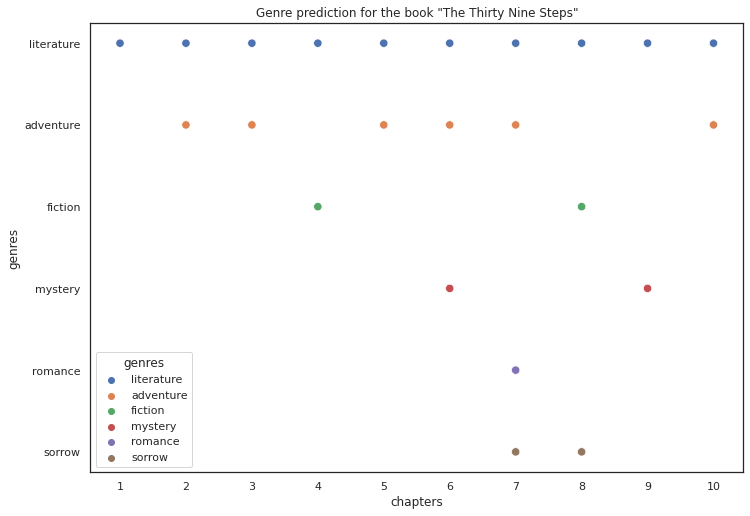

In [67]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
sns.scatterplot(data=plot_dataframe, x="chapters", y="genres", hue="genres",s=70).set(title='Genre prediction for the book "The Thirty Nine Steps"')

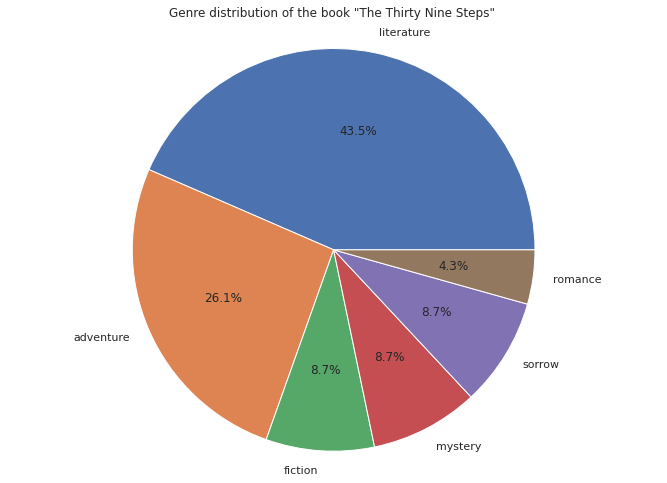

In [72]:
import matplotlib.pyplot as plt


plt.pie(genre_distribution.values(), labels=genre_distribution.keys(),autopct='%1.1f%%')
plt.axis('equal')
plt.title('Genre distribution of the book "The Thirty Nine Steps" ')
plt.show()